In [3]:
# Load the extension, disable it after development
%load_ext autoreload
%autoreload 2

from preprocess import *

import numpy as np
import pandas as pd

from fastdtw import fastdtw
from dtaidistance import dtw

import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

# Game plan
### Reduce complexity or finding time correlations across ips 
We chose agg. window to 15 mins build 96 item vectors
We need fast metric to compute similarities 
Dim reduction + hdbscan


In [5]:
df = pd.read_csv('../data/2019-08-01_test2.csv')
df=df[['ip','timestamp']]

#A = get_aggregated(df, '2019-08-01 00:00:00','2019-08-02 00:00:00')
#A = get_aggregated(df)

tfrom=datetime.datetime.fromisoformat('2019-08-01 00:00:00').timestamp()
tto=datetime.datetime.fromisoformat('2019-08-02 00:00:00').timestamp()

agg_secs = 900
days_proc = 1
corr_window = 1.25

A = df.copy()
A = df[df['timestamp']>=tfrom]
A = A[A['timestamp']<tto]

A['timestamp'] = A.timestamp-tfrom
A['timestamp'] = np.floor(A.timestamp/agg_secs)
Ag = A.groupby('ip')['timestamp'].agg([list, 'count'])

#df['agg']=np.floor(df['timestamp']/900)
#exp=df.groupby('agg')['ip'].agg([set])
#sns.barplot(A['timestamp','count'])

data = Ag[Ag['count'] > 10] #prefiltered data
#data = Ag

### Event count distribution analysis

count    22154.000000
mean        64.912747
std        417.576686
min         11.000000
25%         15.000000
50%         24.000000
75%         60.000000
max      55719.000000
Name: count, dtype: float64


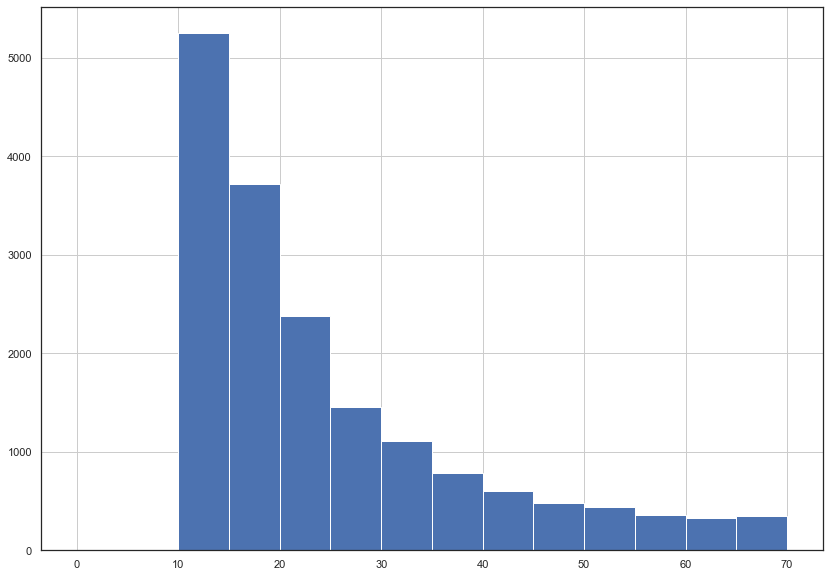

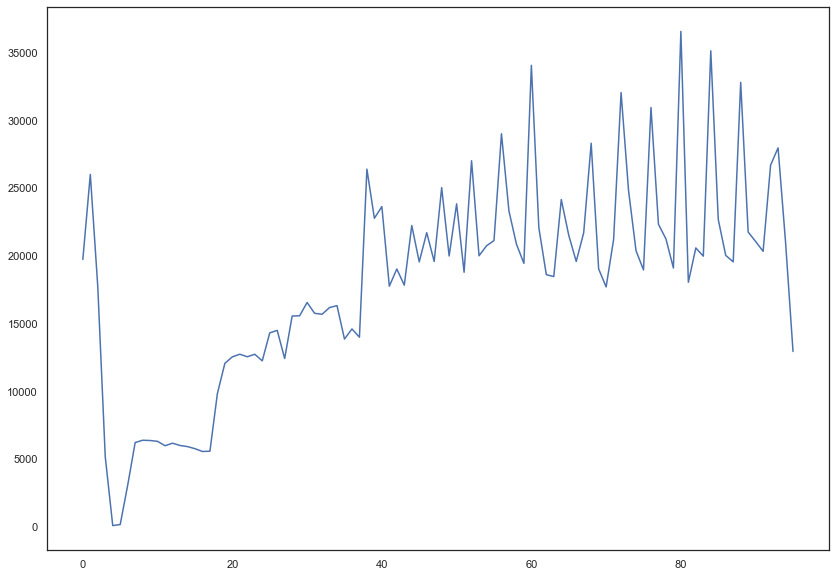

In [6]:
data.head()
print(data['count'].describe())
data['count'].hist(bins=list(range(0,75,5)))
plt.figure()
evt_signal=A.groupby('timestamp')['ip'].agg('count')
sns.lineplot(data=evt_signal)


In [7]:
data['series']=data['list'].apply(get_bin_series, args=[np.int((days_proc*24*3600)/agg_secs)])
data.sort_values('count', inplace=True, ascending=True)
vect=pd.concat([pd.DataFrame(index=data.index, data=np.stack(data.series)),data['count']], axis=1)

vect=pd.DataFrame(index=data.index, data=np.stack(data.series))


C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Invalid use of recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x000002AA71EC92F0>))) with parameters (array(float32, 2d, C), array(int64, 1d, C), array(int64, 1d, C), int64)
No type info available for recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x000002AA71EC92F0>))) as a callable.
[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x000002AA71EC92F0>)))
[2] During: typing of call at C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\rp_tree.py (457)


File "..\..\..\..\..\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

 

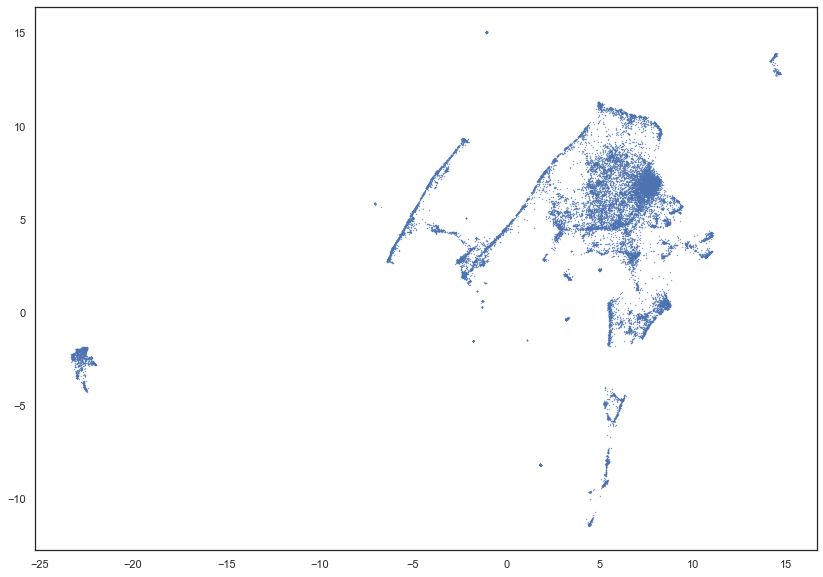

In [6]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(vect)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
           s=0.1, cmap='Spectral')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


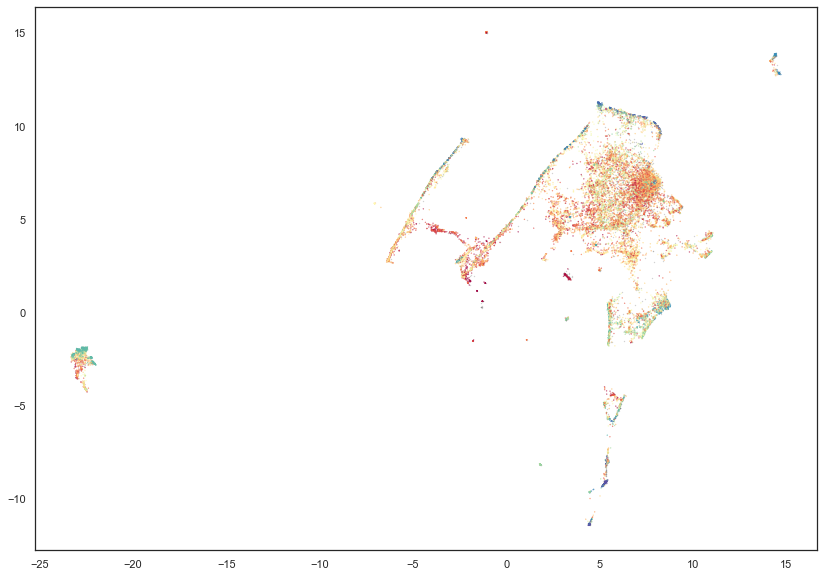

In [8]:
labels = hdbscan.HDBSCAN(
    min_samples=30,
    min_cluster_size=50,
    metric='manhattan'
).fit_predict(vect)

clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


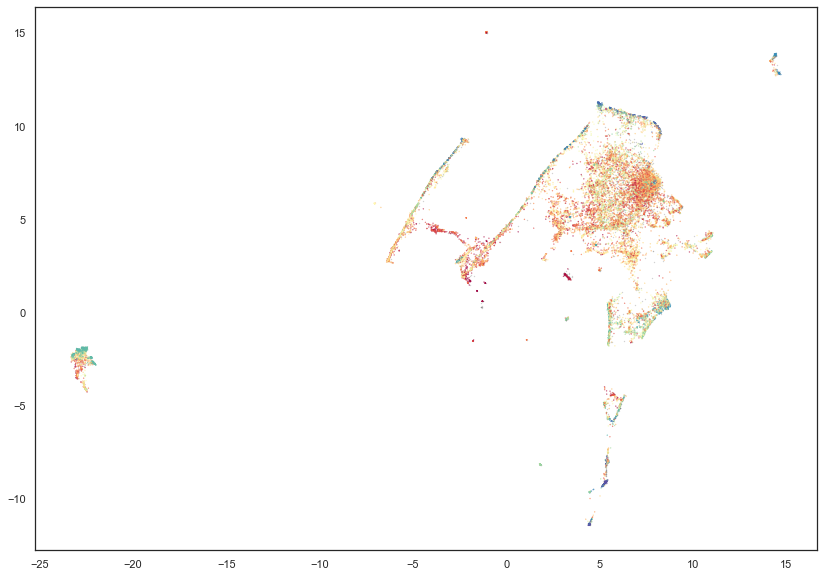

In [10]:
labels = hdbscan.HDBSCAN(
    min_samples=30,
    min_cluster_size=50,
    metric='matching'
).fit_predict(vect)

clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')



In [ ]:
pd.Series(labels).hist()

data['label']=pd.Series(index=data.index, data=labels)
dataS=data.copy()
dataS.sort_values(['count', 'label'], ascending=True, inplace=True)



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


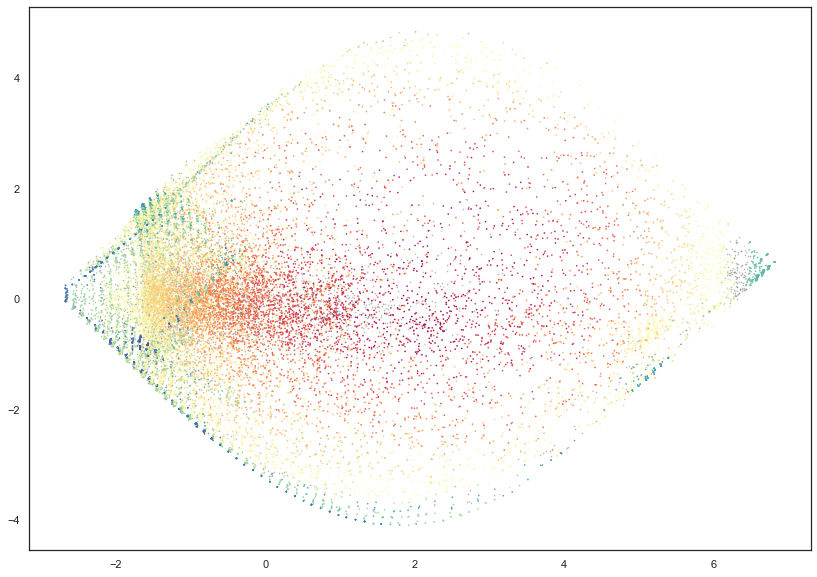

In [12]:
from sklearn.decomposition import PCA
prj=PCA(n_components=2).fit_transform(vect)

clustered = (labels >= 0)
plt.scatter(prj[~clustered, 0],
            prj[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.4,
            alpha=0.5)
plt.scatter(prj[clustered, 0],
            prj[clustered, 1],
            c=labels[clustered],
            s=0.4,
            cmap='Spectral')

In [17]:
from numpy.linalg import norm
data['active']=data['series'].apply(np.sum)

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
lvl = 1000
dmat = np.ones([lvl,lvl])
for x in range(0,lvl):
    for y in range (x+1,lvl):
        #tmp = np.inner(data.iloc[x,0],data.iloc[y,0])/((norm(data.iloc[x,0])*norm(data.iloc[y,0])))
        tmp = np.sum(np.bitwise_and(data.iloc[x,2], data.iloc[y,2]))/max(np.sum(data.iloc[x,2]),np.sum(data.iloc[y,2]))

        dmat[x,y] = tmp
        dmat[y,x] = tmp
      
      

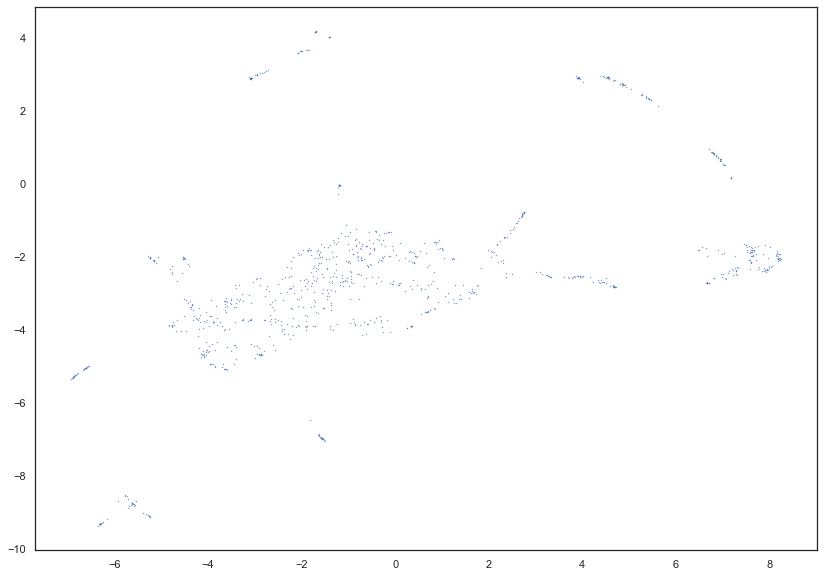

In [46]:
test = umap.UMAP(
    min_dist=0.0,
    n_components=2,
).fit_transform(dmat)

plt.scatter(test[:, 0], test[:, 1],
           s=0.1, cmap='Spectral')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


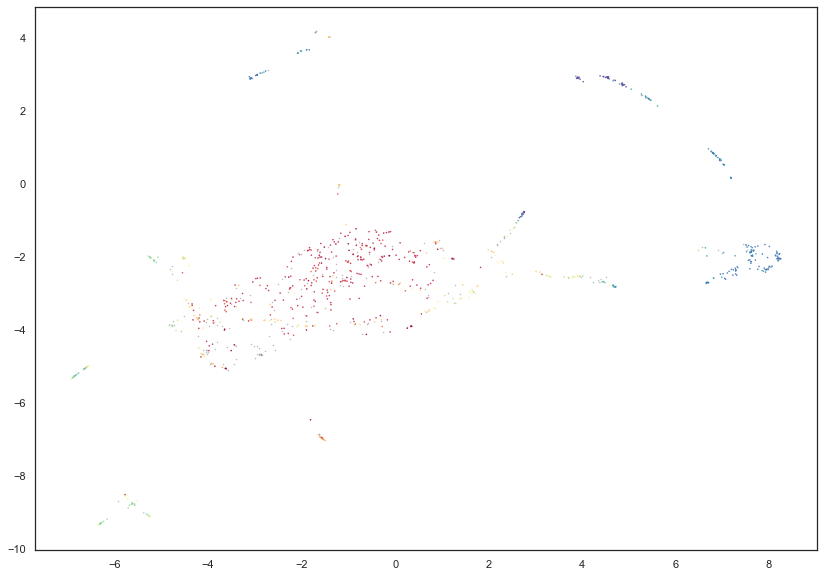

In [47]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric='precomputed'
).fit_predict(dmat)

clustered = (labels >= 0)
plt.scatter(test[~clustered, 0],
            test[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.3,
            alpha=0.5)
plt.scatter(test[clustered, 0],
            test[clustered, 1],
            c=labels[clustered],
            s=0.3,
            cmap='Spectral')

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


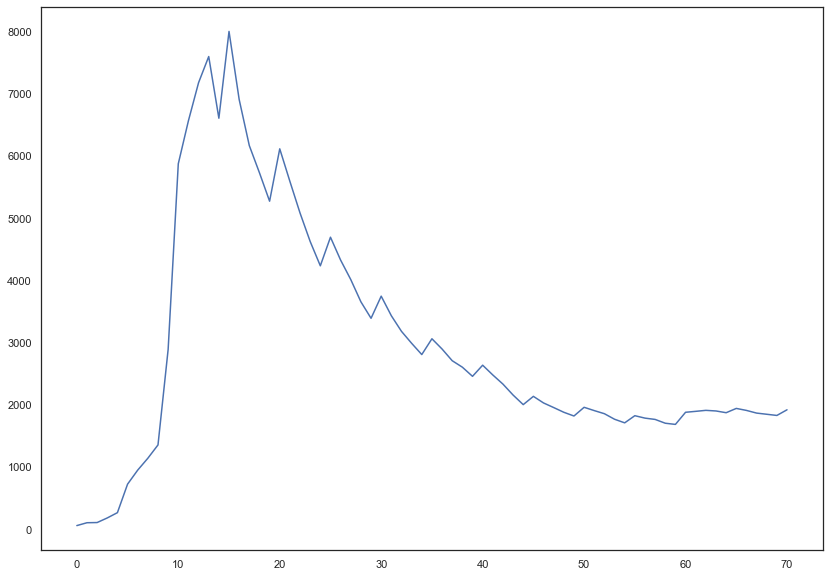

In [14]:
threshold=0.90 #for corelation to be positive at least as much have to match
window_threshold=0.8

dmats={}

stats=[]
data['active']=data['series'].apply(np.sum)


for act in range(1,np.int(np.floor(90*window_threshold))):
    subset = data[data['active']>=act-np.ceil(act*(1-window_threshold))]
    subset = subset[subset['active']<=act+np.floor(act*(1-window_threshold))]
    stats.append(len(subset))
    #dmat = np.zeros([len(subset),len(subset)])
    #for x in range(0,len(subset)):
    #    k1=np.sum(data.iloc[x,2])
    #    for y in range (x+1,len(subset)):
    #        #tmp = np.inner(data.iloc[x,0],data.iloc[y,0])/((norm(data.iloc[x,0])*norm(data.iloc[y,0])))
    #        tmp = 1-np.sum(np.bitwise_and(data.iloc[x,2], data.iloc[y,2]))/np.max(k1,np.sum(data.iloc[y,2]))
    
    #        dmat[x,y] = tmp
    #        dmat[y,x] = tmp
    #dmats[act]=pd.DataFrame(index=subset.index, data=dmat)
            
stats=np.array(stats)
sns.lineplot(data=stats)

In [31]:
from scipy.spatial.distance import squareform, pdist

pairwise = squareform(pdist(vect.iloc[:10000,:],metric='jaccard'))

#sns.heatmap(pairwise, cmap='OrRd', linewidth=1)

MemoryError: 